In [1]:
from collections import deque
from itertools import chain
from itertools import combinations
from itertools import islice
import networkx as nx
from networkx.utils import not_implemented_for

class MaxWeightClique:
    """A class for the maximum weight clique algorithm.
    This class is a helper for the `max_weight_clique` function.  The class
    should not normally be used directly.
    Parameters
    ----------
    G : NetworkX graph
        The undirected graph for which a maximum weight clique is sought
    weight : string or None, optional (default='weight')
        The node attribute that holds the integer value used as a weight.
        If None, then each node has weight 1.
    Attributes
    ----------
    G : NetworkX graph
        The undirected graph for which a maximum weight clique is sought
    node_weights: dict
        The weight of each node
    incumbent_nodes : list
        The nodes of the incumbent clique (the best clique found so far)
    incumbent_weight: int
        The weight of the incumbent clique
    """

    def __init__(self, G, weight):
        self.G = G
        self.incumbent_nodes = []
        self.incumbent_weight = 0

        if weight is None:
            self.node_weights = {v: 1 for v in G.nodes()}
            self.edge_weights = {e: 1 for e in G.edges()}
        else:
            for v in G.nodes():
                if weight not in G.nodes[v]:
                    errmsg = f"Node {v!r} does not have the requested weight field."
                    raise KeyError(errmsg)
                #if not isinstance(G.nodes[v][weight], int):
                #    errmsg = f"The {weight!r} field of node {v!r} is not an integer."
                #    raise ValueError(errmsg)
            self.node_weights = {v: G.nodes[v][weight] for v in G.nodes()}
            for e in G.edges():
                if weight not in G.edges[e]:
                    errmsg = f"Edge {e!r} does not have the requested weight field."
                    raise KeyError(errmsg)
                #if not isinstance(G.edges[e][weight], int):
                #    errmsg = f"The {weight!r} field of edge {e!r} is not an integer."
                #    raise ValueError(errmsg)
            self.edge_weights = {e: G.edges[e][weight] for e in G.edges()}

    def update_incumbent_if_improved(self, C, C_weight):
        """Update the incumbent if the node set C has greater weight.
        C is assumed to be a clique.
        """
        if C_weight > self.incumbent_weight:
            print(C, C_weight)
            self.incumbent_nodes = C[:]
            self.incumbent_weight = C_weight

    def greedily_find_independent_set(self, P):
        """Greedily find an independent set of nodes from a set of
        nodes P."""
        independent_set = []
        P = P[:]
        while P:
            v = P[0]
            independent_set.append(v)
            P = [w for w in P if v != w and not self.G.has_edge(v, w)]
        return independent_set

    def find_branching_nodes(self, P, target):
        """Find a set of nodes to branch on."""
        residual_wt = {v: self.node_weights[v] for v in P}
        total_wt = 0
        P = P[:]
        while P:
            independent_set = self.greedily_find_independent_set(P)
            min_wt_in_class = min(residual_wt[v] for v in independent_set)
            total_wt += min_wt_in_class
            if total_wt > target:
                break
            for v in independent_set:
                residual_wt[v] -= min_wt_in_class
            P = [v for v in P if residual_wt[v] != 0]
        return P
    
    def sum_edge_weights(self, C, v):
        score = 0
        for w in C:
            try: score += self.edge_weights[(v, w)]
            except KeyError: score += self.edge_weights[(w, v)]
        return score

    def expand(self, C, C_weight, P):
        """Look for the best clique that contains all the nodes in C and zero or
        more of the nodes in P, backtracking if it can be shown that no such
        clique has greater weight than the incumbent.
        """
        self.update_incumbent_if_improved(C, C_weight)
        branching_nodes = self.find_branching_nodes(P, self.incumbent_weight - C_weight)
        while branching_nodes:
            v = branching_nodes.pop()
            P.remove(v)
            new_C = C + [v]
            new_C_weight = C_weight + self.node_weights[v] + self.sum_edge_weights(C, v)
            new_P = [w for w in P if self.G.has_edge(v, w)]
            self.expand(new_C, new_C_weight, new_P)

    def find_max_weight_clique(self):
        """Find a maximum weight clique."""
        # Sort nodes in reverse order of degree for speed
        nodes = sorted(self.G.nodes(), key=lambda v: self.G.degree(v), reverse=True)
        nodes = [v for v in nodes if self.node_weights[v] > 0]
        self.expand([], 0, nodes)


@not_implemented_for("directed")
def max_weight_clique(G, weight="weight"):
    """Find a maximum weight clique in G.
    A *clique* in a graph is a set of nodes such that every two distinct nodes
    are adjacent.  The *weight* of a clique is the sum of the weights of its
    nodes.  A *maximum weight clique* of graph G is a clique C in G such that
    no clique in G has weight greater than the weight of C.
    Parameters
    ----------
    G : NetworkX graph
        Undirected graph
    weight : string or None, optional (default='weight')
        The node attribute that holds the integer value used as a weight.
        If None, then each node has weight 1.
    Returns
    -------
    clique : list
        the nodes of a maximum weight clique
    weight : int
        the weight of a maximum weight clique
    Notes
    -----
    The implementation is recursive, and therefore it may run into recursion
    depth issues if G contains a clique whose number of nodes is close to the
    recursion depth limit.
    At each search node, the algorithm greedily constructs a weighted
    independent set cover of part of the graph in order to find a small set of
    nodes on which to branch.  The algorithm is very similar to the algorithm
    of Tavares et al. [1]_, other than the fact that the NetworkX version does
    not use bitsets.  This style of algorithm for maximum weight clique (and
    maximum weight independent set, which is the same problem but on the
    complement graph) has a decades-long history.  See Algorithm B of Warren
    and Hicks [2]_ and the references in that paper.
    References
    ----------
    .. [1] Tavares, W.A., Neto, M.B.C., Rodrigues, C.D., Michelon, P.: Um
           algoritmo de branch and bound para o problema da clique máxima
           ponderada.  Proceedings of XLVII SBPO 1 (2015).
    .. [2] Warrent, Jeffrey S, Hicks, Illya V.: Combinatorial Branch-and-Bound
           for the Maximum Weight Independent Set Problem.  Technical Report,
           Texas A&M University (2016).
    """

    mwc = MaxWeightClique(G, weight)
    mwc.find_max_weight_clique()
    return mwc.incumbent_nodes, mwc.incumbent_weight

In [162]:
import json
import logging
import networkx
import numpy as np

from rdkit import Chem
from func_timeout import func_timeout, FunctionTimedOut
from networkx.algorithms.clique import enumerate_all_cliques, find_cliques, find_cliques_recursive

class CorrespondenceGraph(networkx.Graph):
    '''
    Build the correspondence matrix of putative atom pairings, from which to determine the maximal clique (comprising the MCS). 
    '''
    
    def __init__(self):

        # inherit from networkx.Graph
        super().__init__(self)

    def build(self, mol1, mol2, strictness, correspondence):
        '''
        Build the correspondence graph.
        
        Each atomic pairing is assigned a providional score, from 0 (most different) to 8000 (identical). 
        This pairwise score is appended to the tuple representing each node, following the atomic indices.
        '''
        
        # store strictness for scoring
        self._strict = strictness * 1000
        self._corr = correspondence
        
        # calculate distance matrices
        self._dmat1 = Chem.GetDistanceMatrix(mol1)
        self._dmat2 = Chem.GetDistanceMatrix(mol2)
        
        # extract propery in such a way error is not thrown on comparison
        def getCIPCode(atom):
            try: return atom.GetProp('_CIPCode')
            except KeyError: return None
            
        # create description of how central in molecule atom
        def getPeripherality(atom, dmat):
            peripherality = dmat[atom.GetIdx()]
            return np.mean(peripherality / np.max(peripherality))            
                        
        # build numpy matrix for atom/atom combos
        self._atommaps = []

        # iterate over all potential atom-atom pairings
        for atom1 in mol1.GetAtoms():
            for atom2 in mol2.GetAtoms():

                # set penalties - [penalty] strikes and you're out!
                # TODO: move atomic properies to graph 
                score = 0
                if atom1.GetAtomicNum() == atom2.GetAtomicNum(): score += 1000
                if atom1.GetImplicitValence() == atom2.GetImplicitValence(): score += 1000
                if atom1.GetExplicitValence() == atom2.GetExplicitValence(): score += 1000
                if atom1.GetFormalCharge() == atom2.GetFormalCharge(): score += 1000
                if atom1.GetIsAromatic() == atom2.GetIsAromatic(): score += 1000
                if atom1.GetDegree() == atom2.GetDegree(): score += 1000
                if atom1.IsInRing() == atom2.IsInRing(): score += 1000
                if getCIPCode(atom1) == getCIPCode(atom2): score += 1000

                # apply jitter in the event of a tie
                peripherality1 = getPeripherality(atom1, self._dmat1)
                peripherality2 = getPeripherality(atom2, self._dmat2)
                score += 999 - int(np.floor(999 * abs(peripherality1 - peripherality2)))
                
                # accept node with greater than specified match level
                if score >= self._strict: 
                    newmap = (atom1.GetIdx(), atom2.GetIdx())
                    self._atommaps.append(newmap)
                    self.add_node(self._atommaps.index(newmap), weight=score)
                    
        # build numpy matrix for correspondance combos
        self._corrmat = np.zeros((len(self.nodes), len(self.nodes)), dtype='int64')
        
        # create correspondence graph edges
        for node1 in self.nodes():
            map1 = self._atommaps[node1]
            for node2 in self.nodes():
                map2 = self._atommaps[node2]
                                
                # ensure any given atom is not mapped twice in a clique
                if map1[0] == map2[0] or map1[1] == map2[1]: continue

                # test if criteria are met for correspondence
                correspondence = abs(self._dmat1[map1[0]][map2[0]] - self._dmat2[map1[1]][map2[1]])
                score = int(np.floor(1000/((1+correspondence)**2)))

                if correspondence < self._corr: 
                    self.add_edge(node1, node2, weight=score)
                    self._corrmat[node1][node2] = score

    def solve(self, solver, timeout=60):
        '''
        Enumerate cliques and rescore:
            solver=find_cliques - analyse maximal cliques only (default)
            solver=find_cliques_recursive - (recursively) analyse maximal cliques only
            solver=enumerate_all_cliques - analyse all cliques (not recommended for performance reasons)
        
        Returns:
            bestclique - the best scoring clique (including partially matching atoms, and used to derive reaction mappings)
            bestmcs - the subset of bestclique containing exact chemical matches only (to be discarded to produce the RECS)
        '''
                    
        # define function with no arguments (for use with timeout function)
        def findCliquesNoArgs(): return list(solver(self))
        
        # try finding cliques within [timeout] seconds
        try:
            cliques = func_timeout(timeout, findCliquesNoArgs)
            print(len(self.nodes), len(self.edges), len(cliques))
        except FunctionTimedOut:
            logging.warning(json.dumps({"message": "failed to find cliques in {} seconds".format(timeout)}))
            return list(), list()

        # score (largest cliques first)
        bestscore = -1E800
        cliques.sort(key=len, reverse=True)
        for clique in cliques:
            
            # lookup scores from matrices
            score = np.sum(self._corrmat[clique].T[clique])/2
            score += sum([self.nodes[mapping]['weight'] for mapping in clique])
            
            # store results if best so far
            if score > bestscore:
                bestscore = score
                bestclique = clique  
                
        clique1, clique2 = zip(*[self._atommaps[x] for x in bestclique])
        print(clique1, clique2)

        # work out which atoms comprising the best clique neighbour atoms which remain unpaired
        bestmcs = [x for x in bestclique if self.nodes[x]['weight'] >= 8000] 
        mcs1, mcs2 = zip(*[self._atommaps[x] for x in bestmcs])
        dmat1 = np.delete(self._dmat1, list(mcs1), axis=1)
        dmat2 = np.delete(self._dmat2, list(mcs2), axis=1)
        if dmat1.size != 0: idx1 = np.where(dmat1.min(axis=1) > 1)[0]
        else: idx1 = mcs1
        if dmat2.size != 0: idx2 = np.where(dmat2.min(axis=1) > 1)[0]
        else: idx2 = mcs2
            
        # eliminate those nodes where the constituent atoms do not neighbour outsiders or have atomic differences
        bestmcs = [x for x in bestmcs if self._atommaps[x][0] in idx1 and self._atommaps[x][1] in idx2]
        
        # replace indices with actual mappings for downstream
        bestmcs = [self._atommaps[x] for x in bestmcs]
        bestclique = [self._atommaps[x] for x in bestclique]

        # return results
        print(bestmcs, bestscore)
        return bestclique, bestmcs
                            
    def solve_weighted(self, timeout=60):
        '''
        For testing only, please do not use.
        
        Execute the maximum weight clique search.
        
        Returns:
            clique - the best scoring clique (including partially matching atoms, and used to derive reaction mappings)
            mcs - the subset of bestclique containing exact chemical matches only (to be discarded to produce the RECS)
        '''
                    
        # define function with no arguments (for use with timeout function)
        def findCliquesNoArgs(): return max_weight_clique(self)
        
        # try finding cliques within [timeout] seconds
        try:
            clique, maxweight = func_timeout(timeout, findCliquesNoArgs)
        except FunctionTimedOut:
            logging.warning(json.dumps({"message": "failed to find cliques in {} seconds".format(timeout)}))
            return list(), list()

        # lookup scores from matrices
        score = np.sum(self._corrmat[clique].T[clique])/2
        score += sum([self.nodes[mapping]['weight'] for mapping in clique])

        # work out which atoms comprising the best clique neighbour atoms which remain unpaired
        mcs = [x for x in clique if self.nodes[x]['weight'] >= 8000] 
        mcs1, mcs2 = zip(*[self._atommaps[x] for x in mcs])
        dmat1 = np.delete(self._dmat1, list(mcs1), axis=1)
        dmat2 = np.delete(self._dmat2, list(mcs2), axis=1)
        if dmat1.size != 0: idx1 = np.where(dmat1.min(axis=1) > 1)[0]
        else: idx1 = mcs1
        if dmat2.size != 0: idx2 = np.where(dmat2.min(axis=1) > 1)[0]
        else: idx2 = mcs2
            
        # eliminate those nodes where the constituent atoms do not neighbour outsiders or have atomic differences
        mcs = [x for x in mcs if self._atommaps[x][0] in idx1 and self._atommaps[x][1] in idx2]
        
        # replace indices with actual mappings for downstream
        mcs = [self._atommaps[x] for x in mcs]
        clique = [self._atommaps[x] for x in clique]
    
        # return results
        print(maxweight, score)
        return clique, mcs
        
class MMP():

    @staticmethod
    def __molFromSmiles(smiles: str):
        
        # parse smiles
        try: mol = Chem.MolFromSmiles(smiles)
        except: return None
            
        # add hydrogen where defining isomer
        isomerics = []
        for atom in mol.GetAtoms():
            if not atom.HasProp('_CIPCode'): continue
            isomerics.append(atom.GetIdx())
        mol = Chem.AddHs(mol, onlyOnAtoms=isomerics, explicitOnly=True)
                      
        # clear mappings and initialise radii (assume all atoms are RECS)
        for atom in mol.GetAtoms(): 
            atom.SetProp('molAtomRadius','0')
            atom.ClearProp('molAtomMapNumber')
            
        # return
        return mol
    
    def __init__(self, smiles_x: str, smiles_y: str, strictness=4, correspondence=1):
        '''
        Initialise the matched molecular pair.
        
        smiles_x: First molecule to compare.
        smiles_y: Second molecule to compare.
        strictness: Integer (1-8) to indicate how tolerant the algortithm should to be to atom-wise chemical differences. 
            1 (slowest) all atom types match.
            8 (fastest) atoms chemically identical to be considered part of mcss.  
        correspondence: Integer (1-8) to indicate how tolerant the algortithm should to be to topological differences. 
            1 (fastest) standard MCS using exact correspondance matrix only.
            4 (slowest) atoms are allowed to 'drift' up to [correspondance] bonds away from neighbouring counterparts.  
        '''
        
        if strictness-1 not in range(8): return
        if correspondence-1 not in range(4): return
        
        # canonicalise smiles
        self._smiles1 = Chem.MolToSmiles(Chem.MolFromSmiles(smiles_x))
        self._smiles2 = Chem.MolToSmiles(Chem.MolFromSmiles(smiles_y))
         
        # initialise molecules for comparison
        self._mol1 = self.__molFromSmiles(self._smiles1)
        self._mol2 = self.__molFromSmiles(self._smiles2)
        
        # intialise correspondence graph
        self._graph = CorrespondenceGraph()
        self._graph.build(self._mol1, self._mol2, strictness, correspondence)
        
        # dummy vars
        self._clique = None
        self._mcs = None

    def __setAtomMapNumbers(self):        
        '''
        Use the indices of the best scoring clique to define the atom mappings.
        '''

        # iterate over the mappings identified from MCSS
        for pair in self._clique:
            
            # increment the index to prevent atom mappings of 0
            mapIdx = self._clique.index(pair) + 1
            
            # map first atom and set radius to 99 (atom part of MCS)
            atom1 = self._mol1.GetAtomWithIdx(pair[0])
            atom1.SetProp('molAtomMapNumber', '%d'%mapIdx)
            print('mol1: idx {} map {}'.format(pair[0], mapIdx))
            
            # map second atom and set radius to 99 (atom part of MCS)
            atom2 = self._mol2.GetAtomWithIdx(pair[1])
            atom2.SetProp('molAtomMapNumber', '%d'%mapIdx)
            print('mol2: idx {} map {}'.format(pair[1], mapIdx))

    def __setAtomRadii(self):
        '''
        Use the atomic radii to denote which atoms are part of the MCS. By elimination, those atoms with radii of 0 will form the RECS.
        '''

        # iterate over the remaining mappings identified from MCSS
        for pair in self._mcs:
            
            # map first atom and set radius to 99 (atom part of MCS)
            atom1 = self._mol1.GetAtomWithIdx(pair[0])
            atom1.SetProp('molAtomRadius','99')
            
            # map second atom and set radius to 99 (atom part of MCS)
            atom2 = self._mol2.GetAtomWithIdx(pair[1])
            atom2.SetProp('molAtomRadius','99')

    def execute(self, radii=4, solver=find_cliques):
        '''
        solver = find_cliques, find_cliques_recursive, enumerate_all_cliques, max_weight_clique
        '''

        # find the MCS
        if solver == max_weight_clique: self._clique, self._mcs = self._graph.solve_weighted()
        else: self._clique, self._mcs = self._graph.solve(solver=solver)

        # determine the % of largest molecule covered by MCS
        self._percentmcs = len(self._mcs) / max(self._mol1.GetNumAtoms(), self._mol2.GetNumAtoms())        

        # search, mark up atom mappings and MCS/RECS split
        self.__setAtomMapNumbers()
        self.__setAtomRadii()
                
        # define function for elimination of MCS
        def eliminate(mol, radius):
            
            # environment fails if radius > max distance
            radius = int(min(radius, np.max(Chem.GetDistanceMatrix(mol))))
        
            # tag atoms within 4 bonds of attachment
            toRemove = set(range(mol.GetNumAtoms()))
            for atom in mol.GetAtoms():
                if atom.GetProp('molAtomRadius') == '0':
                    for idx in Chem.FindAtomEnvironmentOfRadiusN(mol, radius-1, atom.GetIdx()):
                        envBond = mol.GetBondWithIdx(idx)
                        toRemove.discard(envBond.GetBeginAtom().GetIdx())
                        toRemove.discard(envBond.GetEndAtom().GetIdx())

            # remove environment from core
            toRemove = list(toRemove)
            toRemove.sort(reverse=True)
            frag = Chem.EditableMol(mol)
            for atom in toRemove: frag.RemoveAtom(atom)
            frag = frag.GetMol()
            return frag
      
        # loop from 4 down to 1 bond radius to find smallest valid transformation
        responselist = list()
        for radius in reversed(range(radii+1)):
            
            # return list of valid transformations
            if radius == 0: return responselist
            
            # initialise response object
            response = {'smiles1': self._smiles1,
                        'smiles2': self._smiles2,
                        'percentmcs': self._percentmcs,
                        'radius': radius,
                        'valid': False}
            
            # Define reaction as SMIRKS while mappings still present
            frag1 = eliminate(self._mol1, radius)
            frag2 = eliminate(self._mol2, radius)   
            print(Chem.MolToSmiles(frag1), Chem.MolToSmiles(frag2))
            smirks = '{}>>{}'.format(Chem.MolToSmarts(Chem.AddHs(frag1)), Chem.MolToSmarts(Chem.AddHs(frag2)))
            response['smirks'] = smirks
            
            # verify 1:1 reaction
            rxn = Chem.rdChemReactions.ReactionFromSmarts(smirks)
            if rxn.GetNumReactantTemplates() != 1 or rxn.GetNumProductTemplates() != 1: 
                logging.info(json.dumps({'radius': radius, "message": "no 1:1 reaction could be generated"}))
                responselist.append(response)
                continue

            # verify derived reaction produces original 'product'
            print(smirks, self._smiles1)
            productset = rxn.RunReactants((Chem.AddHs(Chem.MolFromSmiles(self._smiles1)),))
            productlist = list()
            for product in productset:
                productlist.append('.'.join([Chem.MolToSmiles(Chem.RemoveHs(productpart)) for productpart in product]))
            if self._smiles2 not in productlist:
                logging.info(json.dumps({'radius': radius, "message": "second molecule not found amongst products enumerated from first"}))
                responselist.append(response)
                continue

            # remove mappings to yield clean fragments
            for atom in frag1.GetAtoms(): atom.ClearProp('molAtomMapNumber')
            frag1 = Chem.MolToSmiles(frag1, allHsExplicit=True)
            for atom in frag2.GetAtoms(): atom.ClearProp('molAtomMapNumber')
            frag2 = Chem.MolToSmiles(frag2, allHsExplicit=True)

            # return key response elements
            response['valid'] = True
            response['fragment1'] = frag1
            response['fragment2'] = frag2
            responselist.append(response)

In [163]:
#mmp = MMP('Cc1cccnc1', 'Cc1ccccn1', strictness=1, correspondence=4)
#mmp = MMP('CC(C)NC[C@@H](O)c1ccc(O)c(O)c1', 'CC(C)NC[C@H](O)c1ccc(O)c(O)c1', strictness=5, correspondence=3)
#mmp = MMP('Cc1oc(C)cc1', 'Cc1ccc(C)cc1', strictness=5, correspondence=3)
#mmp = MMP('N1CCC1', 'N1CCNCC1', strictness=5, correspondence=2)
#mmp = MMP('Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1', 'CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C)c2)CC1', strictness=5, correspondence=2)
#mmp = MMP('CC(C)NC[C@H](O)c1ccc(NS(C)(=O)=O)c(O)c1', 'CC(C)NC[C@H](O)c1ccc(O)c(CS(C)(=O)=O)c1', strictness=5, correspondence=2)
mmp = MMP('CCCc1nn(C)c2c(=O)[nH]c(-c3cc(S(=O)(=O)N4CCN(C)CC4)ccc3OCC)nc12', 'CCCc1nc(C)c2c(=O)nc(-c3cc(S(=O)(=O)N4CCN(CC)CC4)ccc3OCC)[nH]n12', strictness=5, correspondence=2)

In [164]:
response = mmp.execute(solver=find_cliques)
response

505 36051 5990911
(11, 10, 31, 9, 8, 4, 6, 0, 1, 2, 3, 5, 7, 32, 12, 25, 26, 13, 18, 27, 21, 14, 22, 28, 29, 30, 17, 15, 16, 24, 20, 23, 19) (11, 10, 32, 9, 8, 4, 6, 0, 1, 2, 3, 5, 7, 33, 12, 26, 27, 13, 18, 28, 21, 14, 22, 29, 30, 31, 16, 15, 17, 19, 24, 20, 25)
[(9, 9), (0, 0), (1, 1), (2, 2), (12, 12), (25, 26), (26, 27), (13, 13), (18, 18), (27, 28), (14, 14), (28, 29), (29, 30), (30, 31), (17, 16), (15, 15), (16, 17), (24, 19), (20, 24), (23, 20), (19, 25)] 815422.0
mol1: idx 11 map 1
mol2: idx 11 map 1
mol1: idx 10 map 2
mol2: idx 10 map 2
mol1: idx 31 map 3
mol2: idx 32 map 3
mol1: idx 9 map 4
mol2: idx 9 map 4
mol1: idx 8 map 5
mol2: idx 8 map 5
mol1: idx 4 map 6
mol2: idx 4 map 6
mol1: idx 6 map 7
mol2: idx 6 map 7
mol1: idx 0 map 8
mol2: idx 0 map 8
mol1: idx 1 map 9
mol2: idx 1 map 9
mol1: idx 2 map 10
mol2: idx 2 map 10
mol1: idx 3 map 11
mol2: idx 3 map 11
mol1: idx 5 map 12
mol2: idx 5 map 12
mol1: idx 7 map 13
mol2: idx 7 map 13
mol1: idx 32 map 14
mol2: idx 33 map 14
mo

[{'smiles1': 'CCCc1nn(C)c2c(=O)[nH]c(-c3cc(S(=O)(=O)N4CCN(C)CC4)ccc3OCC)nc12',
  'smiles2': 'CCCc1nc(C)c2c(=O)nc(-c3cc(S(=O)(=O)N4CCN(CC)CC4)ccc3OCC)[nH]n12',
  'percentmcs': 0.6,
  'radius': 4,
  'valid': False,
  'smirks': '[#6:8](-[#6:9](-[#6:10](-[#6:11]1:[#7:6]:[#7:12](-[#6:7](-[H])(-[H])-[H]):[#6:13]2:[#6:5](=[#8:4]):[#7:2](:[#6:1](-[#6:15](:[#6:18](:[#6:22])-[H]):[#6:20](:[#6:17]-[H])-[#8:24]):[#7:3]:[#6:14]:1:2)-[H])(-[H])-[H])(-[H])-[H])(-[H])(-[H])-[H].[#7:19]1-[#6:33](-[#6:31](-[#7:21](-[#6:23](-[H])(-[H])-[H])-[#6:32](-[#6:30]-1(-[H])-[H])(-[H])-[H])(-[H])-[H])(-[H])-[H]>>[#6:8](-[#6:9](-[#6:10](-[#6:11]1:[#7:6]:[#6:12](-[#6:7](-[H])(-[H])-[H]):[#6:13]2:[#6:5](=[#8:4]):[#7:2]:[#6:1](-[#6:15](:[#6:18](:[#6:22])-[H]):[#6:20](:[#6:17]-[H])-[#8:24]):[#7:3](:[#7:14]:1:2)-[H])(-[H])-[H])(-[H])-[H])(-[H])(-[H])-[H].[#7:19]1-[#6:30](-[#6:32](-[#7:21](-[#6:23](-[#6](-[H])(-[H])-[H])(-[H])-[H])-[#6:31](-[#6:33]-1(-[H])-[H])(-[H])-[H])(-[H])-[H])(-[H])-[H]'},
 {'smiles1': 'CCCc1nn(C)c

In [153]:
def shownodes(x):
    try: return (x, mmp._graph.nodes[mmp._graph._atommaps.index(x)])
    except ValueError: (x, None)
[shownodes(x) for x in mmp._clique]

[((11, 11), {'weight': 8973}),
 ((10, 10), {'weight': 7981}),
 ((31, 32), {'weight': 7972}),
 ((9, 9), {'weight': 8983}),
 ((8, 8), {'weight': 8985}),
 ((4, 4), {'weight': 8981}),
 ((6, 6), {'weight': 8982}),
 ((0, 0), {'weight': 8977}),
 ((1, 1), {'weight': 8977}),
 ((2, 2), {'weight': 8977}),
 ((3, 3), {'weight': 8978}),
 ((5, 5), {'weight': 6983}),
 ((7, 7), {'weight': 8983}),
 ((32, 33), {'weight': 6976}),
 ((12, 12), {'weight': 8963}),
 ((25, 26), {'weight': 8991}),
 ((26, 27), {'weight': 8986}),
 ((13, 13), {'weight': 8985}),
 ((18, 18), {'weight': 8999}),
 ((27, 28), {'weight': 8966}),
 ((21, 21), {'weight': 8988}),
 ((14, 14), {'weight': 8991}),
 ((22, 22), {'weight': 5985}),
 ((28, 29), {'weight': 8966}),
 ((29, 30), {'weight': 8967}),
 ((30, 31), {'weight': 8967}),
 ((17, 16), {'weight': 8996}),
 ((15, 15), {'weight': 8996}),
 ((16, 17), {'weight': 8996}),
 ((24, 19), {'weight': 8995}),
 ((20, 24), {'weight': 8991}),
 ((23, 20), {'weight': 8991}),
 ((19, 25), {'weight': 8995}

In [154]:
minatoms = min(mmp._mol1.GetNumAtoms(), mmp._mol2.GetNumAtoms())
idxclique = [x for x in zip(range(minatoms), range(minatoms))]
[shownodes(x) for x in idxclique]

[((0, 0), {'weight': 8977}),
 ((1, 1), {'weight': 8977}),
 ((2, 2), {'weight': 8977}),
 ((3, 3), {'weight': 8978}),
 ((4, 4), {'weight': 8981}),
 ((5, 5), {'weight': 6983}),
 ((6, 6), {'weight': 8982}),
 ((7, 7), {'weight': 8983}),
 ((8, 8), {'weight': 8985}),
 ((9, 9), {'weight': 8983}),
 ((10, 10), {'weight': 7981}),
 ((11, 11), {'weight': 8973}),
 ((12, 12), {'weight': 8963}),
 ((13, 13), {'weight': 8985}),
 ((14, 14), {'weight': 8991}),
 ((15, 15), {'weight': 8996}),
 ((16, 16), {'weight': 8996}),
 ((17, 17), {'weight': 8996}),
 ((18, 18), {'weight': 8999}),
 ((19, 19), {'weight': 8995}),
 ((20, 20), {'weight': 8991}),
 ((21, 21), {'weight': 8988}),
 ((22, 22), {'weight': 5985}),
 None,
 ((24, 24), {'weight': 8988}),
 ((25, 25), {'weight': 5994}),
 ((26, 26), {'weight': 8980}),
 ((27, 27), {'weight': 5960}),
 None,
 ((29, 29), {'weight': 6934}),
 ((30, 30), {'weight': 5935}),
 None,
 ((32, 32), {'weight': 6980}),
 None]

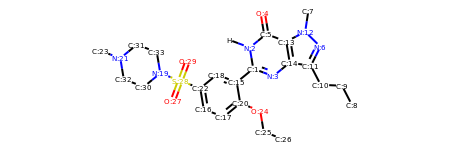

In [155]:
mmp._mol1

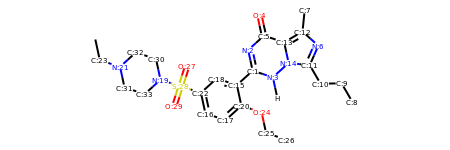

In [156]:
mmp._mol2

In [ ]:
[(mmp._graph._atommaps[e1], mmp._graph._atommaps[e2], mmp._graph.edges[(e1, e2)]) 
 for e1, e2 in mmp._graph.edges() 
 if (mmp._graph._atommaps[e1], mmp._graph._atommaps[e2]) in ((x, y) for x in mmp._clique for y in mmp._clique)]

In [ ]:
[(mmp._graph._atommaps[e1], mmp._graph._atommaps[e2], mmp._graph.edges[(e1, e2)]) 
 for e1, e2 in mmp._graph.edges() 
 if (mmp._graph._atommaps[e1], mmp._graph._atommaps[e2]) in ((x, y) for x in idxclique for y in idxclique)]

RDKit ERROR: [17:16:30] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [17:16:30] Explicit valence for atom # 7 C, 5, is greater than permitted


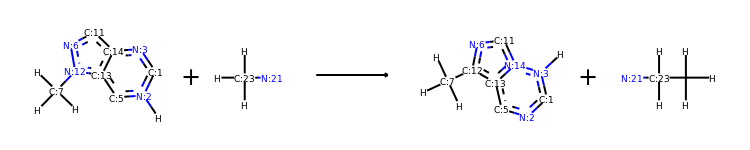

In [161]:
Chem.rdChemReactions.ReactionFromSmarts(response[3]['smirks'])

In [12]:
import scipy.io as sio
m = networkx.to_scipy_sparse_matrix(mmp._graph)
sio.mmwrite('test.mat', m)

In [13]:
m

<34x34 sparse matrix of type '<class 'numpy.int64'>'
	with 836 stored elements in Compressed Sparse Row format>